Example of running semantic segmentation on OCT data.  Note that we do not expect good results yet, in part due to a paucity of training data.  This will be corrected moving forward.

march 2016, mjp

In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys, time
from socket import gethostname
import h5py

import numpy as np
import pylab as plt

np.random.seed(9999)

import keras
from keras import backend as K
from keras.models import load_model

sys.path.append('../..')
import cnn_tools
import data_tools

import oct

K.set_image_dim_ordering('th')
print('Using Keras version: %s' % keras.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using Keras version: 1.1.1


(2, 1, 650, 512) float64
(2, 650, 512) uint32


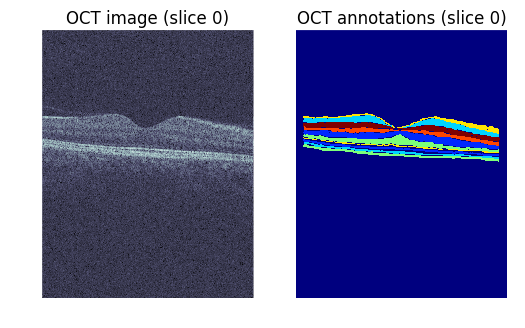

In [57]:
X, Y = oct.load_oct_sample_data('annotated.mat')
print(X.shape, X.dtype)
print(Y.shape, Y.dtype)

# show example data
plt.figure()
plt.subplot(1,2,1)
plt.imshow(X[0,0,...], interpolation='none', cmap='bone')
plt.axis('off')
plt.title('OCT image (slice 0)')

plt.subplot(1,2,2)
plt.imshow(Y[0,...], interpolation='none', cmap='jet')
plt.axis('off')
plt.title('OCT annotations (slice 0)')

#plt.subplot(1,3,3)
#plt.imshow(Y[0,...] > 0, interpolation='none', cmap='jet')
#plt.axis('off')
#plt.title('Binary annotations')

plt.show()

In [58]:
# TODO: get more representative weights after more rigorous training
#weights_file = '../ISBI_2012/weights_epoch0011.hdf5'  # fake weights
weights_file = 'weights_epoch0000.hdf5'
tile_size = (512,512)

# load model
model = cnn_tools.create_unet((1, tile_size[0], tile_size[1]))
model.load_weights(weights_file)
print(model.output_shape)

(None, 1, 512, 512)


In [59]:
# deploy
[X_subset, Y_subset] = data_tools.random_crop((X,Y), tile_size)
print(X_subset.shape)

tic = time.time()
Y_hat = cnn_tools.deploy_model(X_subset, model)
print(Y_hat.shape)
print('[info]: total time to deploy on system "%s": %0.2f sec' % (gethostname(), (time.time() - tic)))

(2, 1, 512, 512)
(2, 1, 512, 512)
[info]: total time to deploy on system "pekalmj1-ml2": 8.65 sec


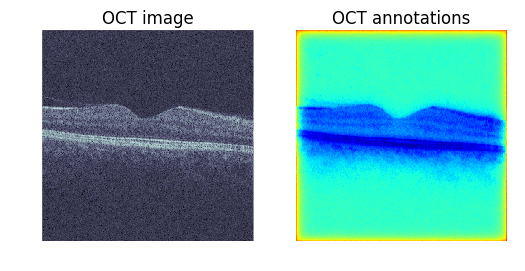

In [60]:
# visualize result
# show example data
plt.figure()
plt.subplot(1,2,1)
plt.imshow(X_subset[0,0,...], interpolation='none', cmap='bone')
plt.axis('off')
plt.title('OCT image')

plt.subplot(1,2,2)
plt.imshow(Y_hat[0,0,...], interpolation='none', cmap='jet')
plt.axis('off')
plt.title('OCT annotations')
plt.show()